In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns

df = pd.read_csv("Data_120294_2023-03-29.csv")


/var/folders/k_/917q0lsn2g199rm9y4s8jy5h0000gn/T/ipykernel_82496/2166429449.py:7: DtypeWarning: Columns (2,64,91,94,97,106,108,109,110,111,112,114,116,119,120,122,127,139,142,143,144,145,152,153,154,155,156,157,159,160,161,163,164,165,169,170,171,172,175,178,179,180,187,189,215,216,217,218,219,317,318) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data_120294_2023-03-29.csv")


[Text(0.5, 0, 'Percentage of missing values'),
 Text(0, 0.5, 'Number of columns')]

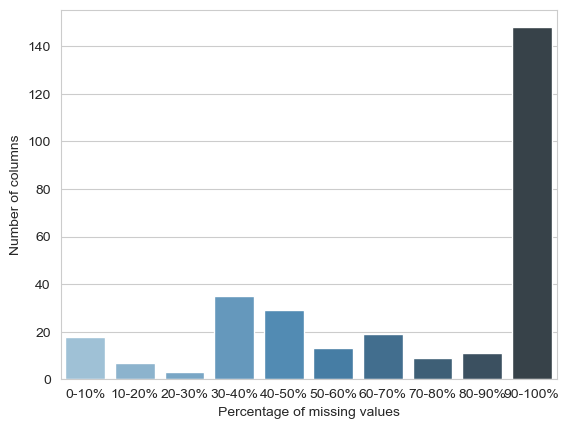

In [25]:
missing_pct = df.isnull().sum() / len(df.index) * 100
bin_edges = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = [f'{i}-{j}%' for i, j in zip(bin_edges[:-1], bin_edges[1:])]

# Bin the columns according to their missing value percentage
bins = pd.cut(missing_pct, bins=bin_edges, labels=bin_labels)

# Count the number of columns in each bin
bin_counts = bins.value_counts().sort_index()

# Create a bar plot of the bin counts
sns.set_style("whitegrid")
ax = sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="Blues_d")
ax.set(xlabel="Percentage of missing values", ylabel="Number of columns")



In [26]:
# Remove rows with no transplant date
pre_len = len(df.index)
df = df[df['tx_date'].notna()]
post_len = len(df.index)
print(f"Filtered to only transplanted patients: {post_len}/{pre_len} ({post_len/pre_len*100:.2f}% remaining)")

# Compute the time to transplant (waitlist time -> wl_time)
df['wl_time'] = (pd.to_datetime(df['tx_date'], format='%d%b%Y') - pd.to_datetime(df['init_date'], format='%d%b%Y')).dt.days

print(f"Mean waitlist time: {df['wl_time'].mean():.2f} days")

Filtered to only transplanted patients: 77410/120264 (64.37% remaining)
Mean waitlist time: 192.53 days


In [27]:
def size(): 
    return len(df.columns)

# Remove columns with all rows missing
pre_drop_len = size()
df = df.dropna(axis=1, how='all')
print(f"Dropped cols with all rows missing ({pre_drop_len} -> {size()})")

# Find all non-numerical columns that we need to transform prior to imputation
non_numerical_cols = df.select_dtypes(exclude=['number']).columns
print(f"Non-numerical columns: {len(non_numerical_cols)}")

categorical_cols = [col for col in non_numerical_cols if df[col].nunique() < 10]
print(f"Categorical columns: {len(categorical_cols)}")

non_numerical_non_categorical_cols = [col for col in non_numerical_cols if col not in categorical_cols]
print(f"Non-numerical non-categorical columns: {len(non_numerical_non_categorical_cols)}")

pre_drop_len = size()
df = df.drop(non_numerical_non_categorical_cols, axis=1)
print(f"Dropped non-numerical non-categorical columns ({pre_drop_len} -> {size()})")

# Drop columns derived from donator
#pre_drop_len = size()
#df = df.loc[:, ~df.columns.str.contains('_don')]
#df = df.loc[:, ~df.columns.str.contains('don_')]
#print(f"Dropped donator-related columns ({pre_drop_len} -> {size()})")

# Drop all rows where 90%-99% of values are missing
pre_drop_len = size()
for col in df.columns:
    if df[col].isnull().sum() / len(df.index) > 0.9:
        df = df.drop(col, axis=1)
print(f"Dropped columns where 90%+ of values are missing ({pre_drop_len} -> {size()})")

# Drop dayswait_chron
pre_drop_len = size()
df = df.drop('dayswait_chron', axis=1)
print(f"Dropped dayswait_chron ({pre_drop_len} -> {size()})")

# Drop columns that have no variance
pre_drop_len = size()
df = df.loc[:, df.apply(pd.Series.nunique) != 1]
print(f"Dropped columns with no variance ({pre_drop_len} -> {size()})")

# print categorical columns left
categorical_cols = [col for col in df.columns if df[col].nunique() < 10]
print(f"Categorical columns: {len(categorical_cols)}")

print(f"Mean waitlist time: {df['wl_time'].mean():.2f} days")



Dropped cols with all rows missing (321 -> 315)
Non-numerical columns: 74
Categorical columns: 57
Non-numerical non-categorical columns: 17
Dropped non-numerical non-categorical columns (315 -> 298)
Dropped columns where 90%+ of values are missing (298 -> 173)
Dropped dayswait_chron (173 -> 172)
Dropped columns with no variance (172 -> 165)
Categorical columns: 93
Mean waitlist time: 192.53 days


In [28]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

categorical_cols = [col for col in df.columns if df[col].nunique() < 10]

encoder = OrdinalEncoder()
encoder.fit(df[categorical_cols]) # Fit the encoder to the categorical columns
encoded_cols = encoder.transform(df[categorical_cols]) # Transform the categorical columns
df[categorical_cols] = encoded_cols # Replace the categorical columns with the encoded columns


In [29]:
from missingpy import MissForest
import time

# Get indices of categorical columns
categorical_indices = [df.columns.get_loc(col) for col in categorical_cols]
cols = df.columns
print(f"Imputing {len(cols)} columns with {df.isnull().sum().sum()} missing values")

mf = MissForest(verbose=True, n_estimators=10)
start = time.time()
df_fit = mf.fit(df, categorical_indices)
df_imputed = mf.transform(df)
end = time.time()
print(f"Imputation took {end-start:.2f} seconds")
df = pd.DataFrame(df_imputed, columns=cols)



Imputing 165 columns with 3264395 missing values


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent wo

Iteration: 0


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.5s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.0s remaining:  

Iteration: 1


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.4s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.9s remaining:  

Iteration: 2


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


In [30]:
df.sample(500)


,num_prev_tx,thoracic_dgn,tah,vas,onvent,icu,inotropic,gender,abo,wgt_kg_tcr,...,simulect_maint,steroids_ind,steroids_maint,prograf_ind,prograf_maint,imuran_ind,imuran_maint,cellcept_ind,cellcept_maint,wl_time
17239,1.0,1999.0,0.0,1.0,1.0,1.0,0.9,0.0,0.0,57.00000,...,0.0,1.0,1.0,0.9,0.9,1.0,1.0,1.0,0.6,5.0
7097,0.0,1999.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0,3.00000,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8,0.9,1.0
41702,0.0,1007.0,0.0,0.3,0.0,0.1,0.2,1.0,7.0,75.20000,...,0.0,1.0,1.0,0.0,1.0,0.6,0.4,0.0,1.0,742.0
20360,0.0,1999.0,0.0,0.0,0.0,0.0,0.1,1.0,7.0,75.84579,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0
64361,0.0,1007.0,0.0,0.1,0.2,0.8,0.7,1.0,0.0,69.85320,...,0.0,1.0,1.0,0.0,1.0,0.4,0.0,0.0,1.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9151,0.0,1200.0,0.0,0.0,0.0,1.0,1.0,1.0,7.0,103.00000,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,80.0
9982,0.0,1000.0,0.0,0.2,0.2,0.5,0.4,1.0,0.0,63.00000,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,35.0
18687,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.00000,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,70.0
58926,0.0,1003.0,0.0,0.5,0.3,0.8,0.7,0.0,0.0,75.00000,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,86.0


In [31]:
df.to_csv("space/imputed3-with-dons.csv", index=False)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


